# Sentiment Analysis on US Airline Reviews

In [1]:
# importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

df = pd.read_csv("../data/Tweets.csv")

Importing necessary libraries for working with textual data, specifically for sentiment analysis using LSTM (Long Short-Term Memory) networks.

We imports the Tokenizer class for text tokenization, the pad_sequences function for padding sequences, the Sequential class for defining a sequential model, and several layer classes such as LSTM, Dense, Dropout, SpatialDropout1D, and Embedding.

In [2]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
df.shape

(14640, 15)

In [3]:
# Columns in dataframe
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [2]:
# only taking text and airline_sentiment column to new dataframe
tweet_df = df[['text','airline_sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [3]:
# removing neutral sentiment
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
print(tweet_df.shape)
tweet_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [4]:
tweet_df["airline_sentiment"].value_counts()

airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64

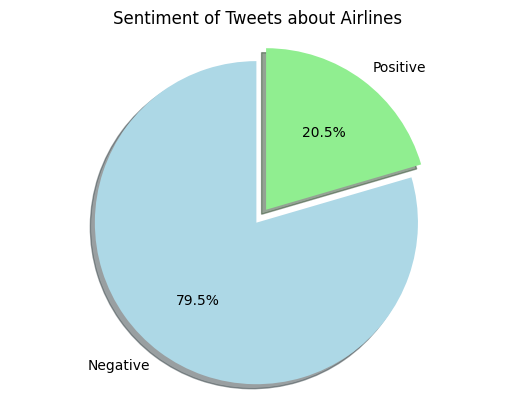

In [7]:
# Create pie chart for the percentage of positive vs negative labeled classes

labels = ['Negative', 'Positive']
sizes = [tweet_df.airline_sentiment.value_counts()[0], tweet_df.airline_sentiment.value_counts()[1]]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # explode positive sentiment

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title("Sentiment of Tweets about Airlines")
plt.show()

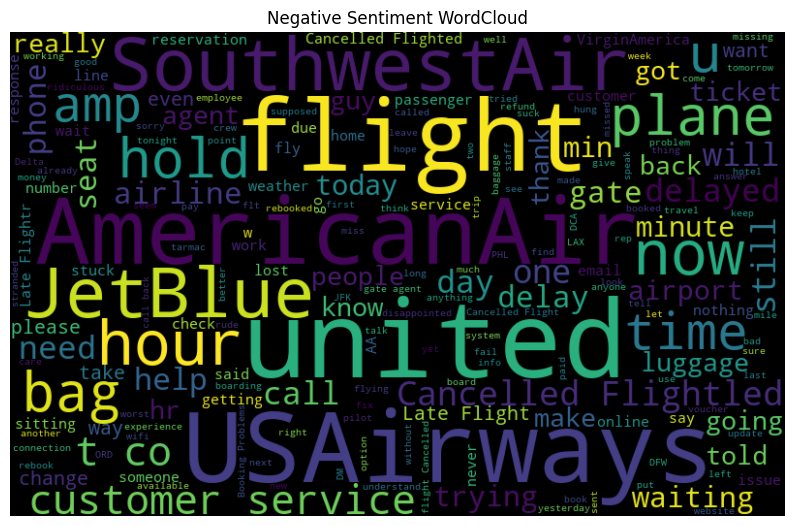

In [8]:
# Create a Wordcloud for negative tweets

from wordcloud import WordCloud

tweet_df_negative = tweet_df[tweet_df['airline_sentiment'] == 'negative']
all_words = ' '.join([text for text in tweet_df_negative['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Negative Sentiment WordCloud")
plt.axis('off')
plt.show()

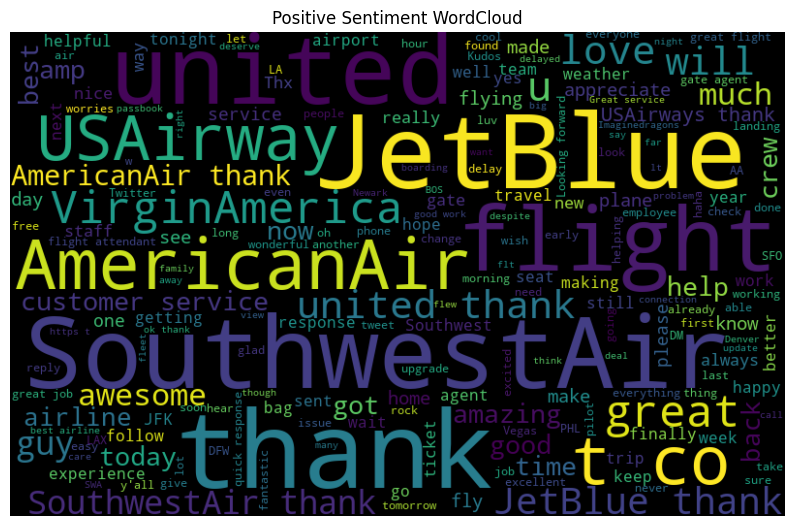

In [7]:
# Create WordCloud for positive tweets

tweet_df_positive = tweet_df[tweet_df['airline_sentiment'] == 'positive']
all_words = ' '.join([text for text in tweet_df_positive['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Positive Sentiment WordCloud")
plt.axis('off')
plt.show()

In [4]:
# The `factorize()` method assigns a unique numerical label to each unique value in the column
sentiment_label = tweet_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [5]:
# Tokenization and Padding

# creating a numpy array of 'text'
tweet = tweet_df.text.values

tokenizer = Tokenizer(num_words=5000) # only top 5000 most fequent words will be considered during tokenization
tokenizer.fit_on_texts(tweet) # it will update the tokenizer's internal vocabulary based on the `tweet` data

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# converting the text data in 'tweet' into sequences of integers
encoded_docs = tokenizer.texts_to_sequences(tweet)

# padding
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
# padding the sequences of word indices to a fixed length of 200
# it will be padded with zeros at the beginning. if a sequence is longer than 200, it will be truncated from the beginning

In [12]:
# print(tokenizer.word_index)
# commented out as it's output is very large
# The `word_index` dictionary is useful for mapping words to indices and vice versa during text processing and model training.

In [13]:
# printing the original text and its corresponding encoded sequence of integers
print(tweet[0])
print(encoded_docs[0])

@VirginAmerica plus you've added commercials to the experience... tacky.
[103, 575, 530, 1287, 2416, 1, 2, 177]


In [14]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  103  575  530 1287
 2416 

In [6]:
# binary classification LSTM model

embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

In [7]:
# training the model
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=4, batch_size=32)

Epoch 1/4
289/289 [==============================] - 26s 79ms/step - loss: 0.3925 - accuracy: 0.8359 - val_loss: 0.2228 - val_accuracy: 0.9177
Epoch 2/4
289/289 [==============================] - 23s 79ms/step - loss: 0.2099 - accuracy: 0.9194 - val_loss: 0.1600 - val_accuracy: 0.9411
Epoch 3/4
289/289 [==============================] - 22s 77ms/step - loss: 0.1596 - accuracy: 0.9407 - val_loss: 0.1632 - val_accuracy: 0.9433
Epoch 4/4
289/289 [==============================] - 23s 78ms/step - loss: 0.1334 - accuracy: 0.9508 - val_loss: 0.1622 - val_accuracy: 0.9420


In [17]:
# Printing Accuracy and Loss

results = model.evaluate(padded_sequence, sentiment_label[0])
print("Loss:", results[0])
print("Accuracy:", results[1])

361/361 [==============================] - 5s 14ms/step - loss: 0.1022 - accuracy: 0.9642
Loss: 0.1021726205945015
Accuracy: 0.964214563369751


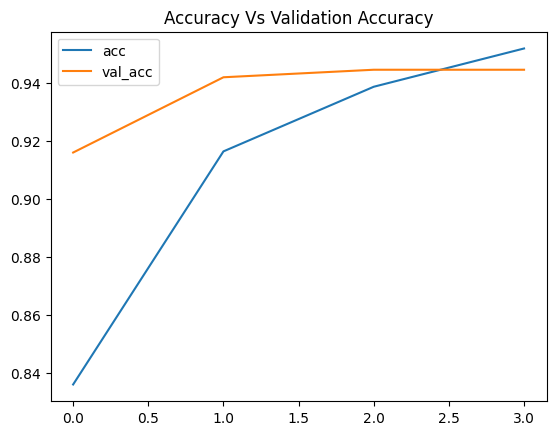

In [19]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy Vs Validation Accuracy")
plt.legend()
plt.show()

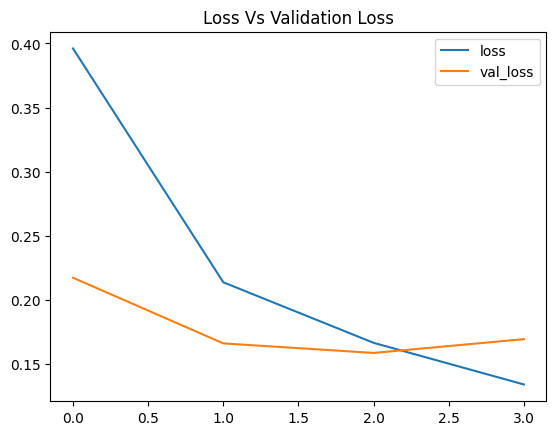

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss Vs Validation Loss")
plt.legend()
plt.show()

In [9]:
# function to predict the sentiment of given 'text'
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    # The prediction is rounded and converted to an integer value
    return sentiment_label[1][prediction]

# The `predict_sentiment` function processes each test sentence by tokenizing, padding, and then predicting the sentiment label using the loaded model.

In [40]:
# predicting value for all data

# Actual sentiments from the DataFrame
actual_sentiments = pd.concat([tweet_df_negative, tweet_df_positive], ignore_index=True)
actual_sentiments['text']

# Predicted sentiments using the sentiment analysis function for each tweet in the DataFrame
predicted_sentiments = ""
predicted_sentiments = predicted_sentiments + actual_sentiments['text'].apply(predict_sentiment)

# this cell take 16 min to run on 11th Gen Intel(R) Core(TM) i5-11400 @ 2.60GHz

1/1 [==============================] - 0s 39ms/step


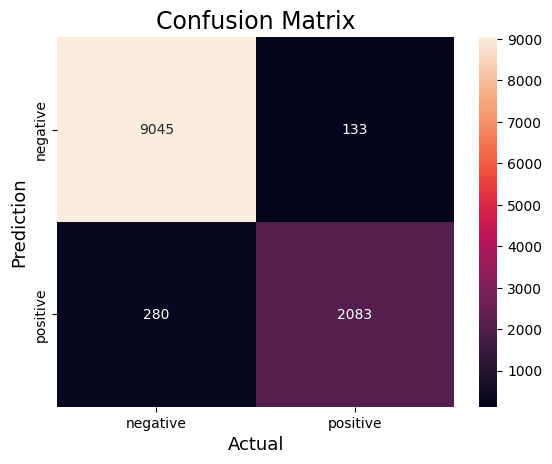

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
confusion_mat = confusion_matrix(actual_sentiments['airline_sentiment'], predicted_sentiments)

# print(confusion_mat)
sns.heatmap(confusion_mat,
            annot=True,
            fmt='g',
            xticklabels=['negative','positive'],
            yticklabels=['negative','positive'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [56]:
Accuracy = metrics.accuracy_score(actual_sentiments['airline_sentiment'], predicted_sentiments)
Accuracy

0.9642145394679837

## Using TextBlob Library

In [ ]:
import nltk
import re
import string
from textblob import TextBlob


def clean_tweet(tweet):
    # Remove special characters
    tweet = "".join(ch for ch in tweet if ch not in string.punctuation)

    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    tweet = " ".join([word for word in tweet.split() if word not in stopwords])

    return tweet


def get_sentiment(tweet):
    # Create a TextBlob object
    analysis = TextBlob(tweet)

    # Get the polarity score of the tweet
    polarity = analysis.sentiment.polarity

    # Return the sentiment according to polarity
    if polarity >= 0:
        return "positive"
    else:
        return "negative"

In [ ]:
# tweets to test the model
tweets = ["I enjoyed my journey on this flight.",
            "This is the worst flight experience of my life!",
            "I loved this journey",
            "This airline has the worst service."]

# Iterate over the tweets
for tweet in tweets:
    # Clean the tweet
    tweet = clean_tweet(tweet)

    # Get the sentiment of the tweet
    sentiment = get_sentiment(tweet)

    # Print the sentiment
    print(f"Tweet: {tweet}.\nSentiment: {sentiment}\n")

Tweet: I enjoyed journey flight.
Sentiment: positive

Tweet: This worst flight experience life.
Sentiment: negative

Tweet: I loved journey.
Sentiment: positive

Tweet: This airline worst service.
Sentiment: negative



In [10]:
# manually predicting sentiment from trained model

test_sentence1 = "I enjoyed my journey on this flight."
print(f'{test_sentence1}\nPredicted label: {predict_sentiment(test_sentence1)}')

test_sentence2 = "This is the worst flight experience of my life!"
print(f'{test_sentence2}\nPredicted label: {predict_sentiment(test_sentence2)}')

test_sentence3 = "I loved this journey"
print(f'{test_sentence3}\nPredicted label: {predict_sentiment(test_sentence3)}')

test_sentence4 = "This airline has the worst service."
print(f'{test_sentence4}\nPredicted label: {predict_sentiment(test_sentence4)}')

1/1 [==============================] - 0s 273ms/step
I enjoyed my journey on this flight.
Predicted label: positive
1/1 [==============================] - 0s 24ms/step
This is the worst flight experience of my life!
Predicted label: negative
1/1 [==============================] - 0s 23ms/step
I loved this journey
Predicted label: positive
1/1 [==============================] - 0s 23ms/step
This airline has the worst service.
Predicted label: negative
